In [1]:
import pandas as pd
import numpy as np
import sys
import h5py
import yaml
import torch
from tqdm import tqdm
import importlib
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import balanced_accuracy_score


sys.path.append('/home/lugeon/eeg_project/scripts')
sys.path.append('/mlodata1/lugeon/eeg_project/scripts')

from training.dataset import datasets
from training.representation import models

import seaborn as sns
sns.set_context("paper")
sns.set(font_scale = 1.6)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

/mlodata1/lugeon/miniconda3/envs/eeg-dream-conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(models)
importlib.reload(datasets)

<module 'training.dataset.datasets' from '/mlodata1/lugeon/eeg_project/scripts/training/dataset/datasets.py'>

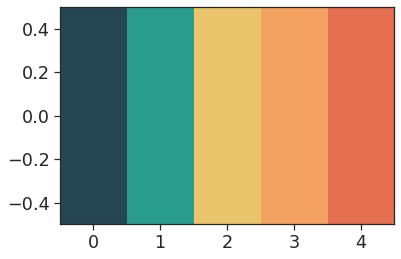

In [3]:
from matplotlib import colors
palette = ['#264653', '#2A9D8F','#E9C46A', '#F4A261', '#E76F51']
cmap = colors.ListedColormap(palette)

plt.imshow(np.arange(len(palette)).reshape(1, -1), aspect='auto', cmap=cmap,origin="lower")
plt.show()

In [5]:
#hdf5_file = '/home/lugeon/eeg_project/dataset_healthy.h5'
#hdf5_file = '/mlodata1/lugeon/dream_data/processed/healthy/dataset.h5'
hdf5_file = '/mlodata1/lugeon/dream_data/processed/madison_20sec/dataset_nrem_binary.h5'


dataset = datasets.EEG_Image_Batch_Dataset(hdf5_file, 
                                           window=1, 
                                           slide=1, 
                                           batch_size=128, 
                                           shuffle=True, 
                                           return_metadata=True,
                                           exclude_subject=[],
                                           output_type='label')

with h5py.File(dataset.hdf5_file, 'r') as f:
    subjects = [s.decode('utf-8') for s in f['subject_name'][:]]
    
dataset

In [7]:
device = torch.device('cuda:0')

result_dir = '/mlodata1/lugeon/eeg_project/results'
#model_name = 'arch_comparison/next_frame_vgg_maxpool'
#model_name = 'arch_comparison/next_frame_baseline'
#model_name = 'transformers/masked_auto_encoder_mask9'
model_name = 'transformers/autoencoder_1frame_mask5'
#model_name = 'cnn/next_frame_vgg_maxpool_index1'


encoder_model_dir = f'{result_dir}/{model_name}'

with open(f'{encoder_model_dir}/train_config.yaml') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)

# get model from model name
model_function = getattr(models, config['model']['name'])
model = model_function(**config['model']['kwargs'])

model.load_state_dict(torch.load(f'{encoder_model_dir}/checkpoint.pt'))

if isinstance(model, models.MaskedAutoEncoder):
    model.masking_ratio = 0.

model.to(device)
model.eval();

## Dream classification

In [8]:
loader = DataLoader(dataset, batch_size=None, shuffle=False)

encodings = []
preds = []
labels = []
subject_ids = []
trial_ids = []
frame_ids = []
sleep_stages = []
elapsed_times = []

with torch.no_grad():
    for input_batch, output_batch, metadata in tqdm(loader, ncols=70):
        
        sid_batch, tid_batch, fid_batch, ss_batch, et_batch = metadata
                            
        # send to device
        input_batch = input_batch.to(device) 
                    
        # forward pass
        encoding_batch = model.encode(input_batch)
        preds_batch = model.forward(input_batch)
        
        if isinstance(model, models.MaskedAutoEncoder) or (
            isinstance(model, models.FineTuner) and isinstance(model.model, models.MaskedAutoEncoder)
        ):
            encoding_batch = encoding_batch.mean(1) # mean across patches
        if isinstance(model, models.FineTuner):
            if model.adverserial:
                preds_batch = preds_batch[0]
        
        encodings.append(encoding_batch.cpu().detach().numpy())
        preds.append(preds_batch.cpu().detach().numpy())
        labels.append(output_batch.cpu().detach().numpy())
        subject_ids.append(sid_batch.cpu().detach().numpy())
        trial_ids.append(tid_batch.cpu().detach().numpy())
        frame_ids.append(fid_batch.cpu().detach().numpy())
        sleep_stages.append(ss_batch.cpu().detach().numpy())
        elapsed_times.append(et_batch.cpu().detach().numpy())
        
        del input_batch
        del output_batch
        del sid_batch
        del ss_batch
        del encoding_batch
        del preds_batch
        
x = np.concatenate(encodings)
p = np.concatenate(preds)
y = np.concatenate(labels)
s = np.concatenate(subject_ids)
t = np.concatenate(trial_ids)
f = np.concatenate(frame_ids)
ss = np.concatenate(sleep_stages)
et = np.concatenate(elapsed_times)

100%|███████████████████████████████| 106/106 [00:26<00:00,  3.97it/s]


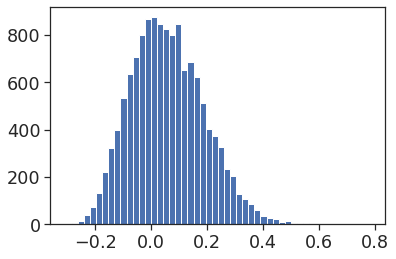

In [9]:
plt.hist(x[:, 0], bins=50);

In [10]:
np.mean(x), np.std(x)

(0.23311643, 0.993744)

In [11]:
add_sex_age = False
add_time = False

if add_sex_age:
    
    df = pd.read_csv(
        '/mlodata1/lugeon/dream_data/chuv/metadata/sex_age_encoding.txt', 
        sep=' ', 
        dtype='str')
    
    map = dict(zip(
        df.id, 
        df.apply(lambda row: [int(d) for d in row.age_encoding + row.sex_encoding], 
                 axis=1)))
    
    missing_subject = set(subjects).difference(set(map.keys()))
    
    add_features = [
        map[subjects[int(id)]] if subjects[int(id)] not in missing_subject 
        else 4*[0] 
        for id in s]
    
    x = np.hstack((x, add_features))
    
if add_time:
    minutes_in_a_day = 60 * 24
    et_norm = et * 2 * np.pi / minutes_in_a_day
    x = np.hstack((x, np.cos(et_norm)[:, np.newaxis], np.sin(et_norm)[:, np.newaxis]))

/mlodata1/lugeon/miniconda3/envs/eeg-dream-conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mlodata1/lugeon/miniconda3/envs/eeg-dream-conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


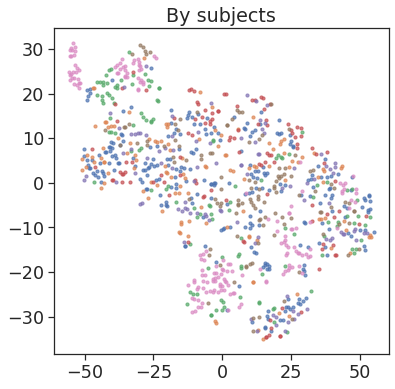

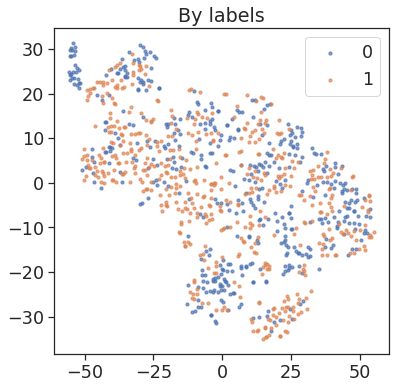

In [12]:
from sklearn.manifold import TSNE

n_samples = 1_000
sample_ix = np.random.choice(x.shape[0], n_samples, replace=False)
sampled_x = x[sample_ix]
sampled_y = y[sample_ix]
sampled_s = s[sample_ix]
#sampled_p = p[sample_ix]

reducer = TSNE(n_components=2)
projection = reducer.fit_transform(sampled_x)

fig, ax = plt.subplots(figsize=(6, 6)) 
for i, sname in enumerate(subjects):
    mask = sampled_s == i
    subject_projection = projection[mask]
    
    plt.scatter(subject_projection[:, 0], subject_projection[:, 1], s=10, alpha=0.7)
    plt.title('By subjects')
plt.show()

fig, ax = plt.subplots(figsize=(6, 6)) 
for i in [0, 1]:
    mask = sampled_y == i
    label_projection = projection[mask]
    plt.scatter(label_projection[:, 0], label_projection[:, 1], s=10, alpha=0.7, label=i)
    plt.legend()
    plt.title('By labels')

### Leave-one-subject-out evaluation

In [13]:
balance_trials = False

df_loso = pd.DataFrame({'fid': f, 
                        'tid': t, 
                        'sid': s, 
                        'label': y,
                        'sleep_stage': ss,
                        'elapsed_time': et})

if balance_trials:
    df_trials = df.groupby(['sid', 'tid']).label.first().reset_index()

    mask = np.zeros(df_trials.shape[0])
    for sid in df_trials.sid.drop_duplicates():
        dfs = df_trials[df_trials.sid == sid]   
        minority = dfs.label.value_counts().min()
        tid_pos = set(dfs[dfs.label == 1].tid.sample(minority))
        tid_neg = set(dfs[dfs.label == 0].tid.sample(minority))
        tid_union = tid_pos.union(tid_neg)
        
        smask = (df_trials.sid == sid) & (df_trials.tid.apply(lambda t: t in tid_union))
        mask = mask + smask.values.astype(int)
        
    selected_trials = df_trials[mask.astype(bool)][['sid', 'tid']]
    selected_trials['select'] = True
    df_loso = df_loso.merge(selected_trials, how='left', on=['sid', 'tid'])
    selected_samples = df_loso.select.notna().astype(bool).tolist()
    df_loso.dropna(inplace=True)
    
else:
    selected_samples = df_loso.shape[0] * [True]

In [14]:
def compute_metrics(encodings, labels, subject_ids, subjects_name, verbose=False, n=10):
    
    np.random.seed(0)
    
    encodings = np.array(encodings)
    labels = np.array(labels)
    
    fprs, tprs, accs, snames = [], [], [], []
    
    scores = np.zeros(len(labels))
    
    if verbose:
        pbar = tqdm(total=len(subjects_name))
    
    for sid, sname in enumerate(subjects_name):
        mask = subject_ids == sid
        mask_id = np.arange(len(labels))[mask]
        
        x_train = encodings[~mask]
        y_train = labels[~mask]

        x_test = encodings[mask]
        y_test = labels[mask]
            
        #clf = LogisticRegression(class_weight='balanced', max_iter=10_000)
        clf = RandomForestClassifier(class_weight='balanced', n_estimators=1_000, max_depth=5, n_jobs=32)
        clf.fit(x_train, y_train)
        
        y_score = clf.predict_proba(x_test)[:, 1]
        scores[mask_id] = y_score
        
        y_pred = clf.predict(x_test)
        
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        acc = sum(y_pred == y_test) / len(y_test)
        
        fprs.append(fpr)
        tprs.append(tpr)
        accs.append(acc)
        snames.append(sname)
        
        if verbose:
            pbar.update(1)
        
    return scores

scores = compute_metrics(x[selected_samples], 
                         df_loso.label, 
                         df_loso.sid, 
                         subjects, 
                         verbose=True)

df_loso['score'] = scores
df_loso['pred'] = (scores >= 0.5).astype(int)

balanced_acc = df_loso.groupby('sid').apply(lambda g: balanced_accuracy_score(g.label, g.pred))

rates = df_loso.groupby('sid').apply(lambda g: roc_curve(g.label, g.score))
rates = rates.apply(lambda r: [r[0].tolist(), r[1].tolist()])

# mean area under the ROC curve
aucs = [auc(fpr, tpr) for (fpr, tpr) in rates]

100%|██████████| 7/7 [00:35<00:00,  5.05s/it]


In [15]:
print(f'LOSO Balanced Acc: {np.mean(balanced_acc) * 100 :.2f} +/- {np.std(balanced_acc) * 100:.2f}')
print(f'LOSO AUC-ROC: {np.nanmean(aucs) * 100 :.2f} +/- {np.nanstd(aucs) * 100:.2f}')

LOSO Balanced Acc: 58.85 +/- 3.66
LOSO AUC-ROC: 65.92 +/- 5.67


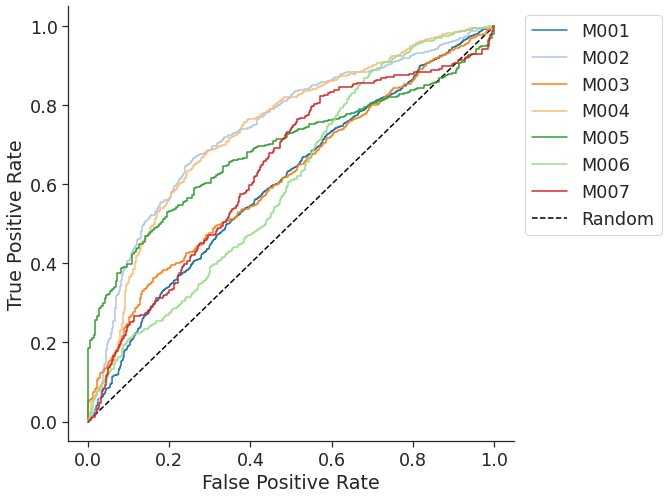

In [17]:
fig, ax = plt.subplots(figsize=(8, 8)) 
cmap = plt.get_cmap('tab20')

i = 0
for r, sname in zip(rates, subjects):
    fpr, tpr = r
    if fpr is not None:
        ax.plot(fpr, tpr, label=sname, color=cmap(i))
    i += 1
    
ax.plot([0, 1], [0, 1], label='Random', linestyle='--', color='black', zorder=0)

plt.legend(bbox_to_anchor=[1.35, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('img/roc.png', bbox_inches='tight')


plt.show()
    

In [18]:
trial_preds = df_loso.groupby(['sid', 'tid']).pred.apply(
    lambda p: sum(p) / len(p)
    ).to_frame().reset_index().rename(columns={'pred': 'majority_score'})

trial_preds = trial_preds.merge(
    df_loso[['sid', 'tid', 'label', 'elapsed_time', 'sleep_stage']].drop_duplicates(['sid', 'tid']), 
    how='left', on=['sid', 'tid'])

trial_preds['majority_pred'] = (trial_preds.majority_score >= 0.5).astype(int)
trial_preds['correct'] = trial_preds.majority_pred == trial_preds.label

In [19]:
majority_acc = trial_preds.groupby('sid').apply(lambda g: sum(g.correct) /g.shape[0])
print(f'Trial majority accuracy: {np.mean(majority_acc) * 100 :.2f} +/- {np.std(majority_acc) * 100:.2f}')

Trial majority accuracy: 66.77 +/- 8.42


### Error distribution

In [18]:
correct_trials = trial_preds[trial_preds.correct]
correct_ss_dist = correct_trials.sleep_stage.value_counts()
correct_ss_dist /= correct_ss_dist.sum()
correct_ss_dist

2    0.608295
3    0.391705
Name: sleep_stage, dtype: float64

In [19]:
incorrect_trials = trial_preds[~trial_preds.correct]
incorrect_ss_dist = incorrect_trials.sleep_stage.value_counts()
incorrect_ss_dist /= incorrect_ss_dist.sum()
incorrect_ss_dist

2    0.503401
3    0.496599
Name: sleep_stage, dtype: float64

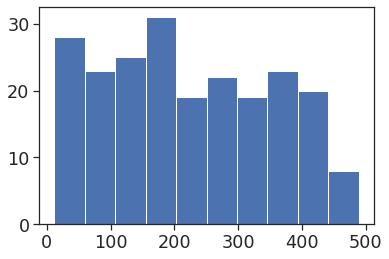

In [20]:
plt.hist(correct_trials.elapsed_time, bins=10);

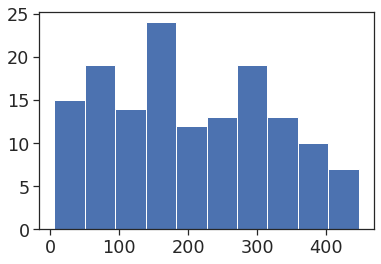

In [21]:
plt.hist(incorrect_trials.elapsed_time, bins=10);

In [137]:
trial_preds['score_delta'] = np.abs(trial_preds.label - trial_preds.majority_score)
trial_preds.sort_values('score_delta', ascending=False)

,sid,tid,majority_score,label,elapsed_time,sleep_stage,majority_pred,correct,score_delta
0,0.0,0.0,0.0,1,28.0,3.0,0,False,1.0
245,4.0,19.0,0.0,1,329.0,2.0,0,False,1.0
249,4.0,23.0,0.0,1,30.0,2.0,0,False,1.0
251,4.0,25.0,0.0,1,94.0,2.0,0,False,1.0
111,1.0,17.0,0.0,1,102.0,3.0,0,False,1.0
...,...,...,...,...,...,...,...,...,...
166,2.0,24.0,1.0,1,20.0,2.0,1,True,0.0
265,5.0,6.0,0.0,0,40.0,3.0,0,True,0.0
99,1.0,5.0,1.0,1,489.0,2.0,1,True,0.0
267,5.0,8.0,1.0,1,193.0,3.0,1,True,0.0


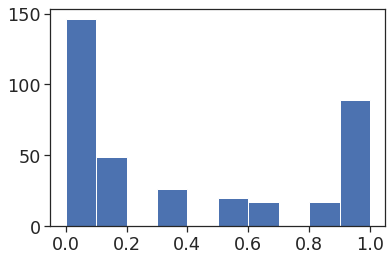

In [140]:
plt.hist(trial_preds.score_delta);

### Trial splitting

In [ ]:
minority_fraction = 0.3
run_number = 100

accs = []
accs_per_subjects = []
tprs_test = []
fprs_test = []
tprs_train = []
fprs_train = []

groupby_trials = pd.DataFrame({'sid': s, 'tid': t, 'label': y}).reset_index().groupby(['sid', 'tid'])

minority_count = groupby_trials.label.apply(lambda s: s.iloc[0]).value_counts().min()
test_class_support = int(minority_fraction * minority_count)

trial_label = groupby_trials.label.apply(lambda s: s.iloc[0]).values
video_idx = groupby_trials.index.apply(list).values
df_trials = pd.DataFrame({'label': trial_label, 'video_idx': video_idx})

neg_trial_idx = df_trials[df_trials.label == 0].index.values
pos_trial_idx = df_trials[df_trials.label == 1].index.values

for i in tqdm(range(run_number), ncols=70):

    neg_permutation = np.random.permutation(np.arange(len(neg_trial_idx)))
    pos_permutation = np.random.permutation(np.arange(len(pos_trial_idx)))

    neg_trial_idx_test = neg_trial_idx[neg_permutation[:test_class_support]]
    neg_trial_idx_train = neg_trial_idx[neg_permutation[test_class_support:]]

    pos_trial_idx_test = pos_trial_idx[pos_permutation[:test_class_support]]
    pos_trial_idx_train = pos_trial_idx[pos_permutation[test_class_support:]]

    trial_idx_test = np.concatenate((neg_trial_idx_test, pos_trial_idx_test))
    trial_idx_train = np.concatenate((neg_trial_idx_train, pos_trial_idx_train))

    train_indices = [i for ix in df_trials.iloc[trial_idx_train].video_idx.values for i in ix]
    test_indices = [i for ix in df_trials.iloc[trial_idx_test].video_idx.values for i in ix]

    x_train = x[train_indices]
    y_train = y[train_indices]
    x_test = x[test_indices]
    y_test = y[test_indices]

    class_weight = 'balanced'
    clf = LogisticRegression(C=1, max_iter=10_000, class_weight=class_weight)
    #clf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight=class_weight)

    clf.fit(x_train, y_train)
    y_test_pred = clf.predict(x_test)
    y_test_score = clf.predict_proba(x_test)[:, 1]

    y_train_pred = clf.predict(x_train)
    y_train_score = clf.predict_proba(x_train)[:, 1]

    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_score)
    acc = sum(y_test_pred == y_test) / len(y_test)
    
    correct_ix = y_test == y_test_pred
    correct_count = pd.DataFrame(s[test_indices][correct_ix], dtype=int).value_counts().sort_index()
    correct_count_ix = [i[0] for i in correct_count.index.to_numpy()]
    
    total_count = pd.DataFrame(s[test_indices], dtype=int).value_counts().sort_index()
    total_count_ix = [i[0] for i in total_count.index.to_numpy()]
    
    total_count_mapped = np.zeros(len(subjects))
    total_count_mapped[total_count_ix] = total_count.values
    correct_count_mapped = np.zeros(len(subjects))
    correct_count_mapped[correct_count_ix] = correct_count.values
    
    with np.errstate(divide='ignore', invalid='ignore'):
        accs_per_subjects.append((correct_count_mapped / total_count_mapped).tolist())
    accs.append(acc)
    tprs_test.append(tpr_test)
    fprs_test.append(fpr_test)
    tprs_train.append(tpr_train)
    fprs_train.append(fpr_train)
    
print(f'Accuracy: {np.mean(accs) * 100 :.2f} +/- {np.std(accs) * 100:.2f}')

In [ ]:
# precision, recall, f1 score
precision_recall_fscore_support(y_test, y_test_pred, average='binary')

In [ ]:
x_interp = np.linspace(0, 1, 100)

test_aucs = []

tprs_test_inter = []
for fpr, tpr in zip(fprs_test, tprs_test):
    tprs_test_inter.append(np.interp(x_interp, fpr, tpr).tolist())
    test_aucs.append(auc(fpr, tpr))
    
tprs_train_inter = []
for fpr, tpr in zip(fprs_train, tprs_train):
    tprs_train_inter.append(np.interp(x_interp, fpr, tpr).tolist())

tpr_train_mean = np.array(tprs_train_inter).mean(axis=0)
tpr_train_std = np.array(tprs_train_inter).std(axis=0)

tpr_test_mean = np.array(tprs_test_inter).mean(axis=0)
tpr_test_std = np.array(tprs_test_inter).std(axis=0)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(x_interp, tpr_train_mean, label='Train', color=cmap(0))
ax.fill_between(x_interp, 
                tpr_train_mean - tpr_train_std, 
                tpr_train_mean + tpr_train_std, 
                color=cmap(0), alpha=0.2)

ax.plot(x_interp, tpr_test_mean, label='Validation', color=cmap(3))
ax.fill_between(x_interp, 
                tpr_test_mean - tpr_test_std, 
                tpr_test_mean + tpr_test_std, 
                color=cmap(3), alpha=0.2)

ax.plot([0, 1], [0, 1], label='Random', linestyle=':', color='grey', zorder=0)
plt.legend()
plt.show()

In [ ]:
print(f'AUC-ROC: {np.mean(test_aucs) * 100 :.2f} +/- {np.std(test_aucs) * 100:.2f}')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5)) 

means = np.nanmean(accs_per_subjects, axis=0)
stds = np.nanstd(accs_per_subjects, axis=0)
pos_fraction_per_subjets = (
    pd.Series(s[y == 1]).value_counts().sort_index().values / 
    pd.Series(s).value_counts().sort_index()).values

maj_fraction_per_subjets = np.where(pos_fraction_per_subjets > 0.5, 
                                    pos_fraction_per_subjets, 
                                    1 - pos_fraction_per_subjets)

sort_ix = np.argsort(means)[::-1]
    
ax.bar(np.arange(len(subjects)), 
        means[sort_ix], 
        yerr=stds[sort_ix], 
        error_kw={
            'capsize': 4,
            'ecolor': 'black',
            'alpha': 0.3
        },
        color=cmap(2),
        alpha=0.8,
        zorder=1,
        label='Accuracy')

ax.scatter(np.arange(len(subjects)), 
            maj_fraction_per_subjets[sort_ix], 
            marker='*',
            s=80,
            color=cmap(0),
            alpha=0.6,
            zorder=2, 
            label='Majority class rate')

ax.plot([0 - .5, len(subjects) - .5], [.5, .5], color='black', alpha=0.5, ls='--', label='Random', zorder=3)

ax.set_xticks(np.arange(len(subjects)))
ax.set_xticklabels(np.array(subjects)[sort_ix], rotation=45, ha='right')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

ax.set_xlim([0 - .8, len(subjects) - 1 + .8])

handles, labels = plt.gca().get_legend_handles_labels()
handles_order = [2, 0, 1]

ax.legend([handles[idx] for idx in handles_order],
          [labels[idx] for idx in handles_order],
          frameon=False, ncol=3, loc='lower center', bbox_to_anchor=(0.45, -0.4))

plt.savefig('acc_per_sub.png', bbox_inches='tight')
plt.plot();

### Evaluation within subjects

In [ ]:
clf = LogisticRegression(class_weight='balanced', max_iter=10_000)

s_accs = []
s_accs_label = []
for i, sname in enumerate(subjects):
    smask = s == i
    xs = x[smask]
    ys = y[smask]
    ts = t[smask]
    trials = pd.Series(ts).drop_duplicates().tolist()
    
    t_accs = []
    t_accs_label = []
    for trial in trials:
        tmask = ts == trial
        x_test = xs[tmask]
        y_test = ys[tmask]
        x_train = xs[~tmask]
        y_train = ys[~tmask]
        
        if (sum(y_train) == len(y_train)) or (sum(1 - y_train) == len(y_train)):
            continue

        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        acc = sum(y_test == y_pred) / len(y_test)
        t_accs.append(acc)
        t_accs_label.append(y_test[0])
        
    s_accs.append(t_accs)
    s_accs_label.append(t_accs_label)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7)) 
    
legend_ne = False
legend_de = False
legend_mean = False

i = 0
for t_accs, t_accs_label in zip(s_accs, s_accs_label):
    for j, acc, t_acc_label in zip(np.arange(len(t_accs)), t_accs, t_accs_label):
        
        rx = (np.random.random() - 0.5) / 3 
        ry = (np.random.random() - 0.5) / 3 / 10
        if (t_acc_label == 0) and not legend_ne: label = 'NE Trial accuracy'; legend_ne = True
        elif (t_acc_label == 1) and not legend_de: label = 'DE Trial accuracy'; legend_de = True
        else: label = None
        if t_acc_label == 0: color = cmap(4)
        else: color = cmap(0)
        plt.scatter(i + rx, acc+ry, color = color, marker='o', alpha=0.2, s=40, label=label)
        
    if len(t_accs) > 0:
        if (not legend_mean) and i > 5: label = 'Mean accuracy'; legend_mean = True
        else: label = None
        ax.scatter(i, np.mean(t_accs), color = 'black', marker='x', alpha=0.7, s=120, label=label)
    ax.plot([i, i], [-0.05, 1], color='grey', alpha=0.1, zorder=0)
        
    i += 1

ax.plot([0 - .5, len(subjects) - .5], [.5, .5], color='black', alpha=0.5, ls='--', label='Random', zorder=0)

ax.set_xticks(np.arange(len(subjects)))
ax.set_xticklabels(subjects, rotation=45, ha='right')

ax.set_ylim([-0.05, 1.05])
ax.set_xlim([0 - .8, len(subjects) - 1 + .8])

plt.legend(bbox_to_anchor=[1, .58], frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

plt.savefig('img/within_subject_pred.pdf', bbox_inches='tight')

plt.plot();

In [ ]:
min_fid = np.min(f)
max_fid = np.max(f)

In [ ]:
(df.groupby(['sid', 'tid']).fid.max() == max_fid).all()

In [ ]:
(df.groupby(['sid', 'tid']).fid.min() == min_fid).all()

In [ ]:
step = 5
width = int( (max_fid - min_fid) / step)
acc_per_video_length = np.zeros(width)

pbar = tqdm(ncols=70, total = width)
for blim in range(0, width):
    mask = f >= min_fid + blim * step
    _, _, accs, _ = compute_metrics(x[mask], y[mask], s[mask], subjects)
    acc_per_video_length[blim] = np.mean(accs)
    pbar.update(1)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6)) 
plt.plot(np.arange(len(acc_per_video_length)), acc_per_video_length)

slide = 0.5 
start = -120
ticks = np.arange(width)
labels = ticks * step * slide + start

ax.set_xticks(ticks)
ax.set_xticklabels(labels)

plt.show()

In [ ]:
labels

In [ ]:
step = 25
width = int( (max_fid - min_fid) / step)
acc_per_video_length = np.zeros((width, width))

pbar = tqdm(ncols=70, total = width ** 2 / 2)

for blim in range(0, width):
    for tlim in range(0, width):
        if blim <= tlim:
            mask = (f >= blim * step) & (f < (tlim + 1) * step)
            
            _, _, accs, _ = compute_metrics(x[mask], y[mask], s[mask], subjects)
            acc_per_video_length[tlim, blim] = np.mean(accs)
            pbar.update(1)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6)) 

plt.imshow(acc_per_video_length, cmap='Blues', vmin=0.5)
plt.colorbar()

ticks = np.arange(width)
labels = ticks * step
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

plt.xlabel('Bottom limit')
plt.ylabel('Top limit')
plt.gca().invert_yaxis()

fig.show()